In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, make_scorer, recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline

# if you are utilizing Google Colab, uncomment below code
# from google.colab import drive
# drive.mount('/content/drive')

## Preprocessing

In [2]:
# Import CSV file
df = pd.read_csv('data/combined_data.csv') # -- local drive import
# df = pd.read_csv('/content/drive/My Drive/Google_Collab/Project_4/data/combined_data.csv') -- Google Colab import 

In [3]:
# View columns to determine which to remove
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'FIRST_MONTH',
       'FINAL_MONTH', 'NUM_OF_MONTHS', 'NUM_OF_DLQ_MONTHS', 'DLQ_PERCENT',
       'RISK_FLAG'],
      dtype='object')

In [4]:
# Review class distribution
df['RISK_FLAG'].value_counts()

RISK_FLAG
0.0    35286
1.0     1171
Name: count, dtype: int64

In [5]:
# Drop unnecessary columns - Version 2. Engineered Variables: only include NUM_OF_DLQ_MONTHS, NUM_OF_MONTHS
df = df.drop(columns=['ID','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','DLQ_PERCENT','FIRST_MONTH','FINAL_MONTH'])

In [6]:
# Fill NaN values with 'NULL'
df = df.fillna({'OCCUPATION_TYPE':'NULL'})

In [7]:
# Put categorical columns into list for encoding
categorical = df.dtypes[df.dtypes == 'object'].index.tolist()

In [8]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse_output= False)

# Fit and transform OneHotEncoder using categorical variables
encode_df = pd.DataFrame(enc.fit_transform(df[categorical]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(categorical)

In [9]:
# Use pd.conat to add columns with encoded values
preprocessed_df = pd.concat([df,encode_df],axis=1)

# Drop object columns
preprocessed_df = preprocessed_df.select_dtypes(exclude=['object'])

In [10]:
# Define X and y variables
y = preprocessed_df['RISK_FLAG']
X = preprocessed_df.drop(columns='RISK_FLAG')

In [11]:
# Split data into training and testing samples. Setting testing population to 30%. Set stratify=y to preserve
# the class distribution

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=36, test_size=0.3, stratify=y)

### Oversampling the minority class via `SMOTE`

In [12]:
# Initialize SMOTE to oversample the minority class in the training data
smote = SMOTE(random_state=29)

# Apply to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [13]:
# Compare class distribution after SMOTE
print(y_train.value_counts())
print(y_train_resampled.value_counts())

RISK_FLAG
0.0    24699
1.0      820
Name: count, dtype: int64
RISK_FLAG
0.0    24699
1.0    24699
Name: count, dtype: int64


In [14]:
# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train_resampled)

# Scaling data on SMOTE resampled training sets
X_train_scaled = X_scaler.transform(X_train_resampled)
X_test_scaled = X_scaler.transform(X_test)

## LogisticRegression Model

### Using X_train, X_test data

In [15]:
# Create a logistic Regression Model
lr_model = LogisticRegression(solver='lbfgs', max_iter= 1000, random_state=42)

# Display model
lr_model

LogisticRegression(max_iter=1000, random_state=42)

In [16]:
# Train the model / time performance
start_time = time.perf_counter()

lr_model = lr_model.fit(X_train_scaled, y_train_resampled)

end_time = time.perf_counter()
lr_total = end_time - start_time

print(f'Execution time: {lr_total} seconds')

Execution time: 0.08428241708315909 seconds


In [17]:
# Making predictions using the testing data
lr_predictions = lr_model.predict(X_test_scaled)

In [18]:
# Display confusion matrix as dataframe
cm1 = confusion_matrix(y_test,lr_predictions)

pd.DataFrame(cm1, index=['Actual 0','Actual 1'],columns=['Predicted 0', 'Predicted 1'])

,Predicted 0,Predicted 1
Actual 0,10554,33
Actual 1,4,347


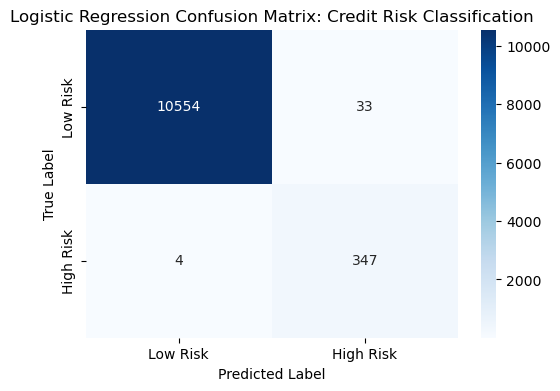

In [19]:
# Create heatmap to visualize performance of the Logistic Regression Model

plt.figure(figsize=(6,4))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])

# Formatting
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression Confusion Matrix: Credit Risk Classification")

# Show the plot
plt.show()


In [20]:
# Display classification report for logistic regression model
lr_class_report = classification_report(y_test, lr_predictions)

print(lr_class_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10587
         1.0       0.91      0.99      0.95       351

    accuracy                           1.00     10938
   macro avg       0.96      0.99      0.97     10938
weighted avg       1.00      1.00      1.00     10938



### Cross-Validation

We are using `StratifiedKFold` during cross validation to ensure that each fold has the same class distribution as the original dataset.\
In the `Pipeline`, we define the steps to take in each fold:
* scale the training data with `StandardScaler`
* use `SMOTE` to re-sample training data

In [21]:
# Define pipeline
pipeline1 = Pipeline([
    ('scaler', StandardScaler()), # Standardize the training data for each fold
    ('smote',SMOTE(random_state=40)), # Resample training data
    ('classifier', lr_model) # use our LogisticRegression model
])

# Define score using make_scorer with a focus on the recall for the negative class (aka Sensitivity)
recall = make_scorer(recall_score, average='binary', pos_label=1)

In [22]:
# Initialize StratifiedKFold into 10 splits
cv = StratifiedKFold(n_splits = 10, shuffle= True, random_state= 67)

In [23]:
# run cross_val_score on the entire dataset. Show total execution time
start_time = time.perf_counter()

lr_cv_scores = cross_val_score(pipeline1, X, y, cv=cv, scoring= recall)

end_time = time.perf_counter()
total = end_time - start_time

print(f'Execution time: {total} seconds')

Execution time: 2.816252041957341 seconds


In [24]:
# Show the average specificity score through all folds
print(f"Average Specificity Score {np.mean(lr_cv_scores)}")

Average Specificity Score 0.9974431406634796


## RandomForest Model

Per `GridSearchCV` results (excluded from this notebook for the sake of brevity), best results for our features achieved with following parameters:
* `n_estimators`: 200
* `min_samples_leaf`: 4 - included to reduce possible overfitting
* `min_samples_split`: 2 - included to reduce possible overfitting

### Using `X_train`, `X_test data`

In [25]:
# Initialize RFClassifier using tuned parameters
rf_model = RandomForestClassifier(n_estimators=200, min_samples_leaf=4, min_samples_split=2, random_state=40)

In [26]:
# Train the model
start_time = time.perf_counter()

rf_model = rf_model.fit(X_train_scaled, y_train_resampled)

end_time = time.perf_counter()
rf_total = end_time - start_time

print(f'Execution time: {rf_total} seconds')

Execution time: 5.350401125033386 seconds


In [27]:
# Make predictions using the testing data
rf_predictions = rf_model.predict(X_test_scaled)

In [28]:
# Display confusion matrix as dataframe
cm2 = confusion_matrix(y_test,rf_predictions)

pd.DataFrame(cm2, index=['Actual 0','Actual 1'],columns=['Predicted 0', 'Predicted 1'])

,Predicted 0,Predicted 1
Actual 0,10541,46
Actual 1,66,285


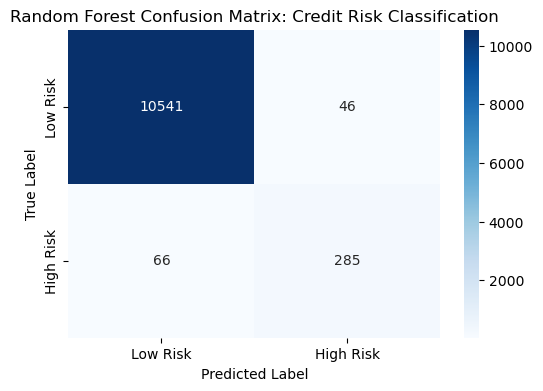

In [29]:
# Create heatmap to visualize performance of the Random Forest Model

plt.figure(figsize=(6,4))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])

# Formatting
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix: Credit Risk Classification")

# Show the plot
plt.show()

In [30]:
# Display classification report for RandomForest model
rf_class_report = classification_report(y_test, rf_predictions)
print(rf_class_report)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     10587
         1.0       0.86      0.81      0.84       351

    accuracy                           0.99     10938
   macro avg       0.93      0.90      0.92     10938
weighted avg       0.99      0.99      0.99     10938



In [31]:
# Display the importance of the features per the RF model, sorted by least to most important
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.5850699622556885, 'NUM_OF_DLQ_MONTHS'),
 (0.03657779062718892, 'FLAG_OWN_REALTY_N'),
 (0.030490949284463296, 'CODE_GENDER_M'),
 (0.02885101952643804, 'NAME_FAMILY_STATUS_Married'),
 (0.02688364706459729, 'FLAG_OWN_CAR_N'),
 (0.026859719220527257, 'CODE_GENDER_F'),
 (0.026193729638058185, 'FLAG_OWN_CAR_Y'),
 (0.02502167934081069, 'NUM_OF_MONTHS'),
 (0.024976066151759863, 'FLAG_OWN_REALTY_Y'),
 (0.016717758139906766, 'NAME_INCOME_TYPE_Commercial associate'),
 (0.01643308184678869, 'NAME_INCOME_TYPE_Working'),
 (0.01585103985705081, 'CNT_FAM_MEMBERS'),
 (0.015156901065201922, 'NAME_EDUCATION_TYPE_Secondary / secondary special'),
 (0.013552967422255098, 'AMT_INCOME_TOTAL'),
 (0.01335446653646773, 'DAYS_BIRTH'),
 (0.012082152824484082, 'DAYS_EMPLOYED'),
 (0.011715751894828009, 'NAME_FAMILY_STATUS_Single / not married'),
 (0.0102503901644818, 'OCCUPATION_TYPE_Laborers'),
 (0.008480605506581978, 'NAME_EDUCATION_TYPE_Higher education'),
 (0.006006924615785311, 'NAME_FAMILY_STATUS_Civil mar

### Cross Validation

In [32]:
# Define pipeline for Cross-Validation of rf model
pipeline2 = Pipeline([
    ('scaler', StandardScaler()), # Standardize the training data for each fold
    ('smote',SMOTE(random_state=42)), # Resample training data
    ('classifier', rf_model) # use our RF model
])

In [33]:
# run cross_val_score on the entire dataset. Show total execution time
start_time = time.perf_counter()

rf_cv_scores = cross_val_score(pipeline2, X, y, cv=cv, scoring= recall)

end_time = time.perf_counter()
total = end_time - start_time

print(f'Execution time: {total} seconds')

Execution time: 64.06672083295416 seconds


In [34]:
print(f"Average Specificity Score {np.mean(rf_cv_scores)}")

Average Specificity Score 0.9385267275097784


## XGBoost

### Using `X_train`, `X_test` data

In [35]:
# Initialize XGBClassifier
xg_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    eval_metric= 'logloss',
    eta= 0.1, # learning rate
    random_state=47)

xg_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [36]:
# Train the model
start_time = time.perf_counter()

xg_model = xg_model.fit(X_train_scaled, y_train_resampled)

end_time = time.perf_counter()
xg_total = end_time - start_time

print(f'Execution time: {xg_total} seconds')

Execution time: 0.21197983401361853 seconds


In [37]:
# Make predictions
xg_predictions = xg_model.predict(X_test_scaled)

In [38]:
# Display confusion matrix as dataframe
cm3 = confusion_matrix(y_test,xg_predictions)

pd.DataFrame(cm3, index=['Actual 0','Actual 1'],columns=['Predicted 0', 'Predicted 1'])

,Predicted 0,Predicted 1
Actual 0,10584,3
Actual 1,1,350


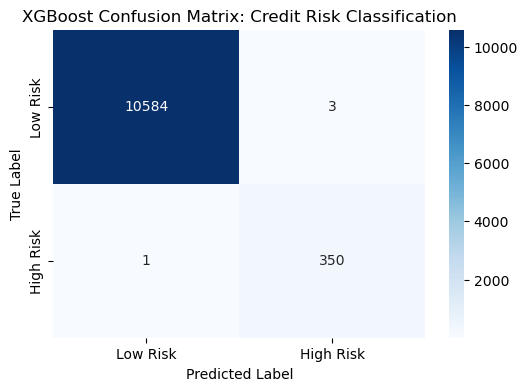

In [39]:
# Create heatmap to visualize performance of the XGBoost Model

plt.figure(figsize=(6,4))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])

# Formatting
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix: Credit Risk Classification")

# Show the plot
plt.show()

In [40]:
# Display confusion matrix as dataframe
cm3 = confusion_matrix(y_test,xg_predictions)

In [41]:
# Display classification report for XGBoost model
xg_class_report = classification_report(y_test, xg_predictions)
print(xg_class_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10587
         1.0       0.99      1.00      0.99       351

    accuracy                           1.00     10938
   macro avg       1.00      1.00      1.00     10938
weighted avg       1.00      1.00      1.00     10938



In [42]:
# Display the importance of the features per the XGBoost model
sorted(zip(xg_model.feature_importances_, X.columns), reverse=True)

[(0.9018393, 'NUM_OF_DLQ_MONTHS'),
 (0.072854534, 'NUM_OF_MONTHS'),
 (0.004517431, 'NAME_HOUSING_TYPE_Office apartment'),
 (0.0038179422, 'NAME_FAMILY_STATUS_Civil marriage'),
 (0.0019568922, 'DAYS_BIRTH'),
 (0.0016166396, 'NAME_FAMILY_STATUS_Single / not married'),
 (0.0015568685, 'OCCUPATION_TYPE_Laborers'),
 (0.0013778979, 'NAME_FAMILY_STATUS_Separated'),
 (0.0013078823, 'CNT_FAM_MEMBERS'),
 (0.001258495, 'NAME_HOUSING_TYPE_Municipal apartment'),
 (0.0009987198, 'CODE_GENDER_F'),
 (0.0006938686, 'NAME_EDUCATION_TYPE_Higher education'),
 (0.0006714875, 'NAME_INCOME_TYPE_Commercial associate'),
 (0.00060138386, 'NAME_FAMILY_STATUS_Married'),
 (0.0005802718, 'OCCUPATION_TYPE_Core staff'),
 (0.00054703496, 'NAME_FAMILY_STATUS_Widow'),
 (0.00050956086, 'DAYS_EMPLOYED'),
 (0.0004124554, 'OCCUPATION_TYPE_High skill tech staff'),
 (0.00038336313, 'FLAG_OWN_CAR_Y'),
 (0.00034523313, 'NAME_EDUCATION_TYPE_Secondary / secondary special'),
 (0.00033079553, 'OCCUPATION_TYPE_Managers'),
 (0.000297

### Cross Validation

In [43]:
# Define pipeline for Cross-Validation of xg model
pipeline3 = Pipeline([
    ('scaler', StandardScaler()), # Standardize the training data for each fold
    ('smote',SMOTE(random_state=42)), # Resample training data
    ('classifier', xg_model) # use our RF model
])

In [44]:
# Run cross_val_score on the entire dataset. Show total execution time
start_time = time.perf_counter()

xg_cv_scores = cross_val_score(pipeline3, X, y, cv=cv, scoring= recall)

end_time = time.perf_counter()
total = end_time - start_time

print(f'Execution time: {total} seconds')

Execution time: 2.498837957973592 seconds


In [45]:
print(f"Average Specificity Score {np.mean(xg_cv_scores)}")

Average Specificity Score 1.0


## Conclusion

In [46]:
# Function to print results
def summary(time,classification_report,cv_scores):
    print(f'Execution time: {time} seconds')
    print("-" * 60)
    print("-" * 60)
    print("Classification Report:")
    print(classification_report)
    print("-" * 60)
    print("-" * 60)
    print(f"Average Specificity Score from Cross Validation {np.mean(cv_scores)}")
    print()
    print()

### **`LogisticRegression`**

In [47]:
summary(lr_total,lr_class_report,lr_cv_scores)

Execution time: 0.08428241708315909 seconds
------------------------------------------------------------
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10587
         1.0       0.91      0.99      0.95       351

    accuracy                           1.00     10938
   macro avg       0.96      0.99      0.97     10938
weighted avg       1.00      1.00      1.00     10938

------------------------------------------------------------
------------------------------------------------------------
Average Specificity Score from Cross Validation 0.9974431406634796




### **`RandomForestClassifier`**

In [48]:
summary(rf_total,rf_class_report,rf_cv_scores)

Execution time: 5.350401125033386 seconds
------------------------------------------------------------
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     10587
         1.0       0.86      0.81      0.84       351

    accuracy                           0.99     10938
   macro avg       0.93      0.90      0.92     10938
weighted avg       0.99      0.99      0.99     10938

------------------------------------------------------------
------------------------------------------------------------
Average Specificity Score from Cross Validation 0.9385267275097784




### **`XGBClassifier`**

In [49]:
summary(xg_total,xg_class_report,xg_cv_scores)

Execution time: 0.21197983401361853 seconds
------------------------------------------------------------
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10587
         1.0       0.99      1.00      0.99       351

    accuracy                           1.00     10938
   macro avg       1.00      1.00      1.00     10938
weighted avg       1.00      1.00      1.00     10938

------------------------------------------------------------
------------------------------------------------------------
Average Specificity Score from Cross Validation 1.0




We recommend the use of the `XGBClassifier` for the task of predicting whether an applicant is high-risk based on credit history. The recall score of the negative (1) class (aka specificity) is the highest of the three models, indicating that the model is performing the best at identifying all high-risk applicants. Additionally, the training execution time of 0.13 seconds indicates that the model is highly efficient.

`RandomForestClassifier` performed the worst of the three, likely due to noise from unnecessary features. A recall score of 0.81 opens up financial liability by potentially misclassifying high-risk applicants. Optimizing this model would require dropping features and tuning the parameters. Additionally, the model took the longest to execute the training cell at 5.38 seconds.

`LogisticRegression` also performed quite well, though the f1-score is lower than `XGBClassifier`. It also had the most efficient run time at 0.13 seconds.